In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

import jax
import jax.numpy as jnp
from scipy.optimize import NonlinearConstraint
jax.config.update("jax_enable_x64", True)
from scipy import optimize
import cvxpy as cp
import sympy as sym

 # №1

$f(x_1, x_2) = \left( x_1 + x_2^2 \right)^2$

$x = ( 1, 0 )$, $p = ( -1, 1 )$ - is a descent direction

$\min\limits_{\alpha > 0} f(x + \alpha p)$

$p \cdot \nabla f < 0$

$$
\nabla f = \left( \frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2} \right)
$$

$$
\nabla f = \left( 2x_1 + 2x_2^2, 4x_1x_2 + 4x_2^3 \right) = \left( 2, 0 \right)
$$

$$p \cdot \nabla f = -2 < 0$$

$$f(x + \alpha p) = f(x_1 - \alpha, x_2 + \alpha) = \left(x_1 - \alpha + (x_2 + \alpha)^2\right)^2$$

$$f(x+\alpha p) = (x_1 - \alpha + x_2^2 + 2\alpha x_2 + \alpha^2)^2$$

$$f(x + \alpha p) = (1 - \alpha + \alpha^2)^2$$

$$\min\limits_{\alpha > 0} (1 - a + \alpha^2)$$

$$-1 + 2\alpha = 0 \rightarrow \alpha = 0.5$$

# №2

$$y_i = e^{x_i}$$

$$x_i = -3 + 6 * \frac{i-1}{k-1}$$

$$k = 201$$

$$f(x) = \frac{a_0 + a_1x + a_2x^2}{1 + b_1x + b_2x^2}$$

$$\max_{i=1}^k |f(x_i) - y_i| \rightarrow \min$$

      fun: 0.02414599338255526
 hess_inv: array([[ 1.64231885e-03, -1.24377460e-03, -7.57288825e-04,
        -4.73385289e-04,  1.08636579e-04],
       [-1.24377460e-03,  3.10929338e-03,  1.33299144e-03,
         1.32618310e-03, -3.32491204e-04],
       [-7.57288825e-04,  1.33299144e-03,  7.95201713e-04,
         6.44662906e-04, -1.57926795e-04],
       [-4.73385289e-04,  1.32618310e-03,  6.44662906e-04,
         6.20700861e-04, -1.56218028e-04],
       [ 1.08636579e-04, -3.32491204e-04, -1.57926795e-04,
        -1.56218028e-04,  3.95155175e-05]])
      jac: array([-3.67328454e-08, -7.76101239e-08, -3.44065894e-07,  2.18651814e-06,
        6.79405363e-06])
  message: 'Optimization terminated successfully.'
     nfev: 403
      nit: 228
     njev: 403
   status: 0
  success: True
        x: array([ 1.009752  ,  0.61198069,  0.11355026, -0.41455087,  0.04849228])

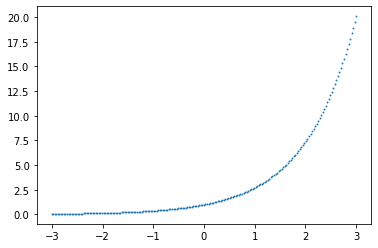

In [2]:
np.random.seed(42)

k = 201
X = np.linspace(-3, 3, k)
Y = np.exp(X)
plt.scatter(X, Y, s = 0.8)

def f(x, a):
    return (a[0] + a[1] * x + a[2] * x**2) / (1 + a[3] * x + a[4] * x**2)

def loss(a):
    P = 50
    return jnp.sum((f(X, a) - Y)**P) ** (1/P)

a0 = np.random.normal(size=5)
res = optimize.minimize(
    loss, # Loss function
    a0,   # Initial value
    jac  = jax.grad(loss),
    method = 'BFGS'
)
res

In [3]:
np.max(f(X, res.x) - Y)

0.023256293420192774

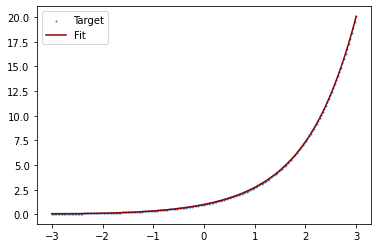

In [4]:

plt.scatter(X, Y, s=0.8, label='Target')
plt.plot(X, f(X, res.x), color='darkred', label="Fit")
plt.legend()

# №4

$ u_0 = argmin _{u∈R^d, |u|=1} u^T A u $, A  - симметричная

Чтобы найти 2 минимальных собственных значения, можно минимизировать сумму:

$ u_0, v_0 = argmin _{u, v ∈R^d, |u|=1, |v|=1} u^T A u + v^T A v $

А также, по определению, имеем:

$(u, v) = 0$

In [5]:
np.random.seed(56)

def get_symm_matrix(N: int):
    b = np.random.random_integers(-10,10, size=(N,N))
    return (b + b.T)/2

N = 10
A = get_symm_matrix(N)

def f(x):
    u = x[0: N]
    v = x[N: 2*N]
    return u @ A @ u + v @ A @ v

def c1(x):
    return x[0: N] @ x[0: N] - 1

def c2(x):
    return x[N: 2*N] @ x[N: 2*N] - 1

def equal(x):
    # условие, что вектора должны быть ортогональны
    return jnp.dot(x[0:N], x[N:2*N])


constraints = [
    NonlinearConstraint(c1, 0, 0,
                        jac=jax.grad(c1)),
    NonlinearConstraint(c2, 0, 0,
                        jac=jax.grad(c2)),
    NonlinearConstraint(equal, 0, 0,
                        jac=jax.grad(equal)),
    
]


u0 = np.random.normal(size=N)
u0 = u0 / (u0 @ u0)**0.5

v0 = np.random.normal(size=N)
v0 = v0 / (v0 @ v0)**0.5
init= np.concatenate((u0, v0))

res = optimize.minimize(
               fun=f, 
               x0=init, 
               jac=jax.grad(f), 
               hess=jax.hessian(f),
               method='trust-constr', 
               tol=1e-5, 
               constraints=constraints)
sol = res["x"]


# для сверки
eigenvalues = np.linalg.eigvals(A)
print(sorted(eigenvalues)[:2])

/var/folders/33/pml9j82x2hz0y5wjjt4ws6sm0000gn/T/ipykernel_65389/2188689045.py:4: DeprecationWarning: This function is deprecated. Please call randint(-10, 10 + 1) instead
  b = np.random.random_integers(-10,10, size=(N,N))


[-22.498087297192807, -21.981531353169977]


In [6]:
vecs_solution = np.reshape(sol, (2, N))
print("Они ортогональны:", vecs_solution[0]@vecs_solution[1])
u_, v_ = vecs_solution[0] @ A @ vecs_solution[0], vecs_solution[1] @ A @ vecs_solution[1]
# найденные значения, с хорошей точностью
u_, v_


Они ортогональны: -9.783156593934977e-15


(-22.467672185024554, -22.011946465340145)

# №5 

/var/folders/33/pml9j82x2hz0y5wjjt4ws6sm0000gn/T/ipykernel_65389/782398993.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  setup = np.array(list(pd.read_pickle("data/data_sensors.pickle").values()))


Text(0, 0.5, 'Y')

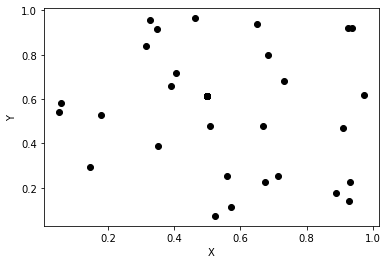

In [7]:
import jax.numpy as jnp
from jax import grad, jit

np.random.seed(50)

setup = np.array(list(pd.read_pickle("data/data_sensors.pickle").values()))
# все вектора двухмерные

def loss(x):
    total_loss = 0
    # просто так массивы не поумножаешь, minimize их норовит выпрямить в 1-dim
    i, j, n = setup[:, 0], setup[:, 1], setup[:, 2]
    for k in range(len(n)):
        tmp = jnp.array([x[i[k]] - x[j[k]], x[LEN_TASK + i[k]] - x[LEN_TASK + j[k]]])
        total_loss += (tmp - n[k]*(tmp @ n[k]))**2
    return jnp.sum(total_loss)


grad_loss_function = grad(loss)
LEN_TASK = len(setup[:, 2])

x0 = np.random.random_sample(2*LEN_TASK)
sol = optimize.minimize(
    loss, # Loss function
    x0,   # Initial value
    jac  = jax.grad(loss),
    method = 'BFGS'
)
res = sol["x"]

# нарисуем точки сенсоров на плоскости
res = res.reshape((2, LEN_TASK))
plt.plot(res[0], res[1], color='black', marker='o', linestyle = '')
plt.xlabel("X")
plt.ylabel("Y")

In [8]:
sol["message"]

'Optimization terminated successfully.'

# №6

/var/folders/33/pml9j82x2hz0y5wjjt4ws6sm0000gn/T/ipykernel_65389/1815392493.py:5: RuntimeWarning: divide by zero encountered in divide
  Z1 = X / Y
/var/folders/33/pml9j82x2hz0y5wjjt4ws6sm0000gn/T/ipykernel_65389/1815392493.py:5: RuntimeWarning: invalid value encountered in divide
  Z1 = X / Y


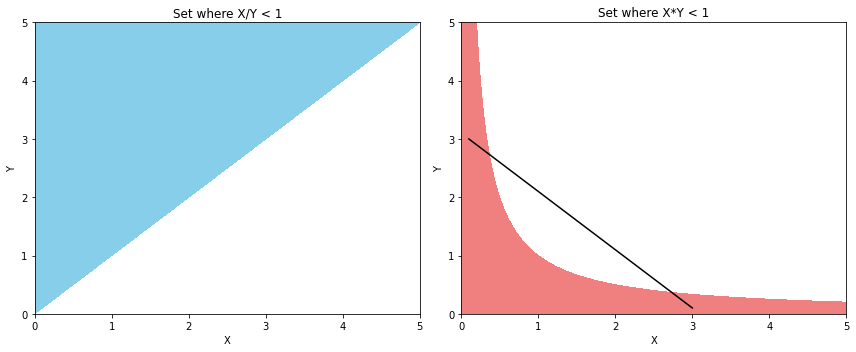

In [9]:
# R^2_{++} -- set of positive real numbers
x = np.linspace(0, 5, 400)
y = np.linspace(0, 5, 400)
X, Y = np.meshgrid(x, y)
Z1 = X / Y
Z2 = X * Y

# Plot x/y 
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.contourf(X, Y, Z1, levels=[-np.inf, 1], colors='skyblue')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Set where X/Y < 1')

# Plot x*y 
plt.subplot(1, 2, 2)
plt.contourf(X, Y, Z2, levels=[-np.inf, 1], colors='lightcoral')
plt.plot([0.1, 3], [3, 0.1], color = "black") # контрпример, множество не выпуклое
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Set where X*Y < 1')

plt.tight_layout()
plt.show()
# a, b, d -- выпуклые, d -- не выпуклое


# №7

(a) f$(x, y) = x^2/y, y>0$

$$\nabla^2 f  = \left( \begin{matrix} \frac{2}{y} & \frac{-2x}{y^2}  \\ \frac{-2x}{y^2}& \frac{2x^2}{y^3} \end{matrix} \right)$$

$\forall v$: $v^T \nabla^2 f(x) v = \frac{2}{y} \left( v_1^2 + \frac{x^2 v_2^2}{y^2} - \frac{2v_1v_2x}{y} \right) = \frac{2}{y} \left( v_1 - \frac{v_2 x}{y} \right)^2 > 0$


(c) $f(x) = ln \sum_{k=1}^n e^{x_k}$, $x \in R^n$

$$\nabla^2 f = \left( \begin{matrix} \frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1\partial x_2} & ... \\ ... & ... & ... \end{matrix} \right)$$

$$\frac{\partial^2 f}{\partial x_i^2} = \frac{\partial}{\partial x_i}\left(\frac{1}{\sum_{k=1}^n e^{x_k}} e^{x_i}\right)$$

$$\frac{\partial^2 f}{\partial x_i^2} = \frac{1}{\sum_{k=1}^n e^{x_k}}e^{x_i} - \frac{1}{\left(\sum_{k=1}^n e^{x_k}\right)^2}e^{2x_i}$$

$$\frac{\partial^2 f}{\partial x_i\partial x_j} = \frac{\partial}{\partial x_j} \left( \frac{1}{\sum_{k=1}^ne^{x_k}} e^{x_i} \right)$$

$$\frac{\partial^2 f}{\partial x_i\partial x_j} = -\frac{1}{\left(\sum e^{x_k}\right)^2}e^{x_i + x_j}$$

$$\xi = \left( e^{x_1}, e^{x_2}, ... \right)$$

$$\nabla^2 f = \frac{1}{\vec 1 \cdot \xi} \text{diag} (\xi) - \frac{1}{\left(\vec 1 \cdot \xi\right)^2} \xi\xi^T$$

$\forall v$: $v^T \nabla^2 f(x) v \ge 0$

$$\frac{\sum \xi_i v_i^2}{\sum \xi_i} - \frac{(\sum v_i \xi_i)^2}{\left(\sum \xi_i\right)^2} \ge 0$$

# №10

/Users/zugzvangg/.pyenv/versions/3.10.5/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


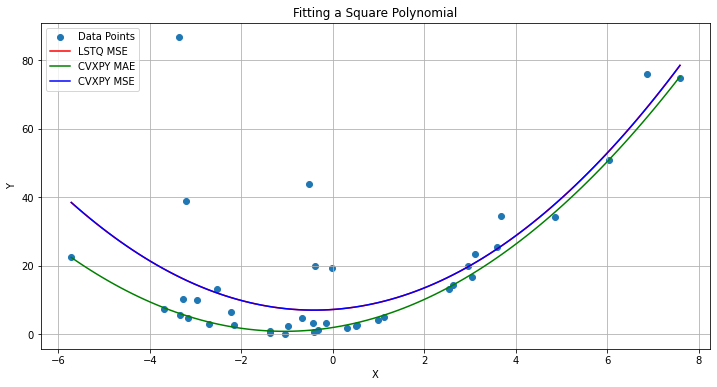

In [10]:
exq10_data = np.load('data/data_fit.npz')
x, y = exq10_data["x"], exq10_data["y"]
A = np.vstack([x**2, x, np.ones_like(x)]).T
coefficients_lstsq, _, _, _ = np.linalg.lstsq(A, y, rcond=None)

a = cp.Variable()
b = cp.Variable()
c = cp.Variable()

cp.Problem(cp.Minimize(cp.sum(cp.abs(a*x**2 + b*x + c - y)))).solve()
coefficients_l1 = [a.value, b.value, c.value]

cp.Problem(cp.Minimize(cp.sum_squares(a*x**2 + b*x + c - y))).solve()
coefficients_l2 = [a.value, b.value, c.value]

x_fit = np.linspace(min(x), max(x), 100)
y_fit_lstsq = coefficients_lstsq[0] * x_fit**2 + coefficients_lstsq[1] * x_fit + coefficients_lstsq[2]
y_fit_l1 = coefficients_l1[0] * x_fit**2 + coefficients_l1[1] * x_fit + coefficients_l1[2]
y_fit_l2 = coefficients_l2[0] * x_fit**2 + coefficients_l2[1] * x_fit + coefficients_l2[2]

# Plot the data points and the fitted polynomial curve
plt.figure(figsize=(12, 6))
plt.scatter(x, y, label='Data Points')
plt.plot(x_fit, y_fit_lstsq, color='red', label='LSTQ MSE')
plt.plot(x_fit, y_fit_l1, color='green', label='CVXPY MAE')
plt.plot(x_fit, y_fit_l2, color='blue', label='CVXPY MSE')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitting a Square Polynomial')
plt.legend()
plt.grid(True)
plt.show()

# оптимизировать MAE по сравнению с MSE лучше
# с MSE CVXPY и np.linalg.lstsq справились одинаково

# №11

In [11]:
data = np.load('data/data_linprog.npz')
X = data['X']
y = data['y']

n, k = X.shape

c = np.ones(2*k) 
A_eq = np.hstack((X, -X)) 
b_eq = y  

bounds = [(-100, 100) for _ in range(2*k)]

res = sp.optimize.linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

optimal_a = res.x[:k] - res.x[k:]

non_zero_elements = np.count_nonzero(optimal_a)

print(f"The optimal 'a' has {non_zero_elements} non-zero elements.")
print(f"a norm {np.sum(abs(optimal_a))}")
print(f"Are equal: {np.allclose(X@optimal_a, y, atol=5)}")

The optimal 'a' has 10 non-zero elements.
a norm 9.634439501271785
Are equal: True


# №12

$$y_i = a \cdot x_i + \epsilon_i$$

Minimize: $L_n(a) = \sum\limits_i \left( y_i - a \cdot x_i \right)^2 + \lambda \|a\|_n$

In [12]:
ex7_data_path = 'data/data_regr.npz'
ex7_data = np.load(ex7_data_path)
X = ex7_data['X']
y = ex7_data['y']
n = y.shape[0]
k = X.shape[1]
n,k

(200, 100)

In [13]:
def solve(l):
    a = cp.Variable(k)
    loss = cp.sum((y - X @ a)**2) + l * cp.norm(a, 2)
    objective = cp.Minimize(loss)
    problem = cp.Problem(objective, None)
    return problem.solve(), a.value

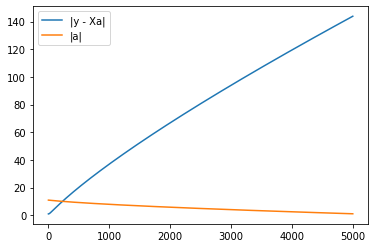

In [14]:
ls = np.linspace(0, 5000, 500)
rs = np.zeros(ls.shape)
an = np.zeros(rs.shape)
for i in range(ls.shape[0]):
    print(f"{i=}", end='\r')
    _, a1 = solve(ls[i])
    rs[i] = np.linalg.norm(y - X @ a1)
    an[i] = np.linalg.norm(a1)

plt.plot(ls, rs, label='|y - Xa|')
plt.plot(ls, an, label='|a|')
plt.legend()

# №13

Find: $r \in R^2$ - source

Given $r_1, r_2, ..., r_m \in R^2$ - detectors

Given $d_1, d_2, ..., d_m \in R$ - distances $\|r-r_k\|_2$

$$L(r) = \sum\left( \|r-r_k\|_2^2 - d_k^2 \right)^2$$

$\min\limits_{r,t} \sum(t + \|r_k\|^2  2r\cdot r_k -d_k^2)^2$ s.t. $\|r\|_2^2=t$

$\bar L (x,y,t) = \sum(t + \|r_k\|^2 - 2r \cdot r_k - d_k^2)^2 + \lambda (\|r\|^2 - t)$

In [15]:
P = np.load("data/P.npy")
d = np.load("data/d.npy")
# эиа функция не выпуклая. она представляет собой полином 4-й степени по r
# где есть слагаемые как четных, так и нечетных степеней

In [16]:
P

array([[-1.84625944, -8.8926792 ],
       [ 5.77069755, -4.2538963 ],
       [-0.99298826, -3.92175389],
       [ 0.52799049,  2.47624426],
       [ 5.53550915,  3.72483291]])

In [17]:
d

array([15.83664881,  7.40992648, 12.20264784,  9.10339534,  4.44793155])

In [18]:
# построим на примере 2-х сенсоров
x, y, t, d1, d2, r1x, r1y, r2x, r2y, lamb = sym.symbols('x, y, t, d_1, d_2, r_1_x, r_1_y, r_2_x, r_2_y, lambda')
r1 = sym.Matrix([r1x, r1y])
r2 = sym.Matrix([r2x, r2y])
r = sym.Matrix([x, y])
L = (
    (t + r1x**2 + r1y**2 - 2*(x*(r1x + r1y) + y*(r1x + r1y)) - d1**2)**2 +
    (t + r2x**2 + r2y**2 - 2*(x*(r2x + r2y) + y*(r2x + r2y)) - d2**2)**2 + 
    lamb*(x**2 + y**2 - t)
    )
dLdx = sym.simplify(sym.diff(L, x))
dLdy = sym.simplify(sym.diff(L, y))
dLdlamb = sym.diff(L, lamb)
dLdt = sym.simplify(sym.diff(L, t))
dLdt

-2*d_1**2 - 2*d_2**2 - lambda + 2*r_1_x**2 + 2*r_1_y**2 + 2*r_2_x**2 + 2*r_2_y**2 + 4*t - 4*x*(r_1_x + r_1_y) - 4*x*(r_2_x + r_2_y) - 4*y*(r_1_x + r_1_y) - 4*y*(r_2_x + r_2_y)

In [19]:
dLdy

2*lambda*y + 4*(r_1_x + r_1_y)*(d_1**2 - r_1_x**2 - r_1_y**2 - t + 2*x*(r_1_x + r_1_y) + 2*y*(r_1_x + r_1_y)) + 4*(r_2_x + r_2_y)*(d_2**2 - r_2_x**2 - r_2_y**2 - t + 2*x*(r_2_x + r_2_y) + 2*y*(r_2_x + r_2_y))

In [20]:
dLdx

2*lambda*x + 4*(r_1_x + r_1_y)*(d_1**2 - r_1_x**2 - r_1_y**2 - t + 2*x*(r_1_x + r_1_y) + 2*y*(r_1_x + r_1_y)) + 4*(r_2_x + r_2_y)*(d_2**2 - r_2_x**2 - r_2_y**2 - t + 2*x*(r_2_x + r_2_y) + 2*y*(r_2_x + r_2_y))

In [21]:
dLdt

-2*d_1**2 - 2*d_2**2 - lambda + 2*r_1_x**2 + 2*r_1_y**2 + 2*r_2_x**2 + 2*r_2_y**2 + 4*t - 4*x*(r_1_x + r_1_y) - 4*x*(r_2_x + r_2_y) - 4*y*(r_1_x + r_1_y) - 4*y*(r_2_x + r_2_y)

In [22]:
from sympy.solvers.solveset import linsolve
sym13 = linsolve([dLdx, dLdy, dLdt], (x, y, t))
# дальше не знаю, даже для 2-х сенсоров выражение большое, для n тем более

# №14

In [23]:
pred = np.load("data/pred.npy")
omega = np.load("data/cov.npy")


In [24]:
# task1
gamma = 0.01
pi = cp.Variable(len(omega))
res1 = cp.Problem(cp.Maximize(pred[0]@pi - pi.T@omega@pi - gamma*cp.sum(cp.abs(pi)))).solve()
pi_zero = pi.value
print("G = ", res1)
print("Pi zero = ", pi_zero)

G =  0.45008068834266435
Pi zero =  [ 1.57942466e-21  8.46907744e+00 -8.32919392e-22  4.68450576e-22
 -1.98622872e-01 -1.90055041e+00 -1.02172722e-22  7.05994196e-22
  2.04096356e+00 -2.82280157e+00  1.61320433e+00 -2.63921215e-21
 -3.41401160e+00 -1.75265939e-21  2.91228126e+00  1.31637858e+01
  2.59319297e-21  4.86795951e+00  3.93783458e-21 -2.27531951e-21]


In [25]:
def solve14(gamma):

    pi_pred = pi_zero
    Gs, pis, costs, gains = [], [], [], []
    for i in range(1, len(pred)):
        pi = cp.Variable(len(omega))
        res = cp.Problem(cp.Maximize(pred[i]@pi - pi.T@omega@pi - gamma*cp.sum(cp.abs(pi - pi_pred)))).solve()

        Gs.append(res)
        pis.append(pi.value)

        gains.append(pred[i]@pi.value)
        costs.append(gamma*np.sum(np.abs(pi.value - pi_pred))  )

        pi_pred = pi.value

    # task4
    print("Gain:", sum(gains))      
    print("Cost:", sum(costs))
    print("Gs:", sum(Gs))
    return pis
    
# task2
_ = solve14(0.01)
# task3
print("="*5)
_ = solve14(0.00)

Gain: 895.9844799618637
Cost: 35.08880299488907
Gs: 413.32265753528094
=====
Gain: 1119.4531862904375
Cost: 0.0
Gs: 559.73232225553
